# Forming teams via integer programs
2023-02-10
ESI 4611 / EIN 6905

In this notebook, we will:
1. Generate a set of students with comfort (on a scale of 1 to 5) in three different categories: "Coding", "Theory", and "Writing"
2. Allocate students to teams of 2 or 3 to maximize the minimize comfort of any team

## Import statements

In [21]:
import pandas as pd
import numpy as np
import math # for ceil

# Fix the randomness
np.random.seed(42)

## Generate students

In [22]:
# Generate a set of students with comfort (on a scale of 1 to 5) in three different categories: "Coding", "Theory", and "Writing"
NUM_STUDENTS = 37
categories = ["Coding", "Theory", "Writing"]
students = [i for i in range(0, NUM_STUDENTS)]

# Generate a random comfort score for each student in each category
comfort_scores = np.random.randint(1, 6, size=(NUM_STUDENTS, len(categories)))

# Sort them lexicographically by "Coding", then "Theory", then "Writing
comfort_scores = sorted(comfort_scores, key=lambda x: (x[0], x[1], x[2]))

# Create a dictionary of the comfort of each student in each category
# The keys are tuples of (student, category), and the values are the comfort scores
comfort = {}
for i in range(0, NUM_STUDENTS):
    for j in range(0, len(categories)):
        comfort[(i, categories[j])] = comfort_scores[i][j]

# Create a dataframe of the comfort of each student in each category
# The columns are the categories, and the rows are the students
# There should be one row per student, one column per category, and the index will be the students
df = pd.DataFrame(
    # data = np.random.randint(1, 6, size=(NUM_STUDENTS, len(categories))),
    # use the dictionary of comfort values
    data = [[comfort[(i,j)] for j in categories] for i in students],
    columns=categories,
    index=students,
)

display(df.head())

,Coding,Theory,Writing
0,1,1,1
1,1,2,5
2,1,3,3
3,1,3,5
4,1,4,1


In [23]:
# Visualize the comfort of each student in each category
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df, annot=True, cmap="YlGnBu", ax=ax)
ax.set_title("Comfort of Students in Each Category")
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

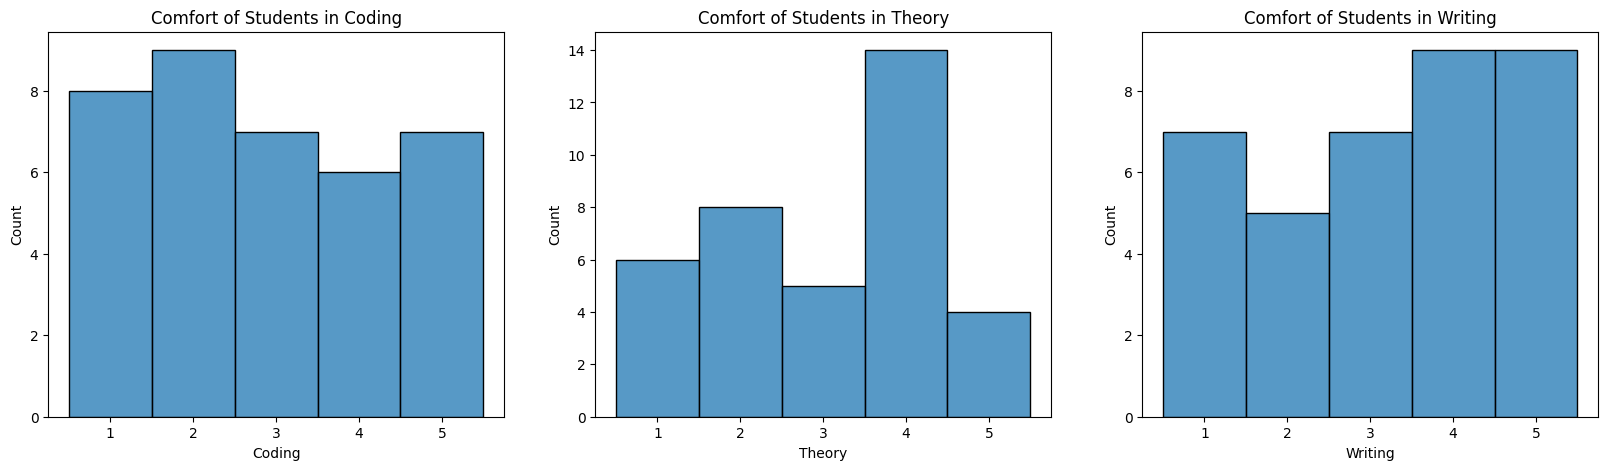

In [ ]:
# Plot 3 bar plots showing the frequency of the comfort of each student in each category with each x-axis being 1, 2, 3, 4, 5
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, category in enumerate(categories):
    # Make histogram for category
    sns.histplot(df[category], ax=ax[i], kde=False, discrete=True)
    ax[i].set_title(f"Comfort of Students in {category}")
plt.show()

## Create integer programming model

Variables
1. x_{ij} binary, representing that student i is assigned to team j
2. y_{j} binary, representing if the team exists
3. z, representing the minimum comfort of any team
4. comfort_j, representing the comfort of team j

Objective: maximize the minimum comfort of any team
max { min_{j \in Teams} comfort_j } --> nonlinear
max z

Constraints:
1. Each student is in exactly one team

\sum_{j \in Teams} x_{ij} = 1 for all i \in Students

2. Number of students on a team is at least 2 *if* that team is not empty

\sum_{i \in Students} x_{ij} \ge 2 y_{j} for all j \in Teams

3. Number of students on a teams is at most 3

\sum_{i \in Students} x_{ij} \le 3 y_{j} for all j \in Teams

4. z represents the minimum comfort of any team

z \le comfort_j + 45 (1-y_j) for all j \in Teams

5. comfort_j is the comfort of team j, weighted by category

comfort_j = 
    \sum_{k \in Categories} weight[categories[k]] * \sum_{i \in Students} comfort[(i, categories[k])] x_{ij}

6. Other constraints as needed (number of teams, minimum comfort level in any category, etc.). For example, to view teams more easily, you may want to sort them by their total weighted comfort.

comfort_j \ge comfort_{j-1} for all j \in Teams \setminus \{0}

### Prepare model: import statements

In [ ]:
# Use Gurobi to create teams of 2 or 3 students
# The df dataframe contains the comfort of each student in coding, theory, and writing
# The goal is to maximize the minimum total comfort of any team
%pip install -q gurobipy
import gurobipy as gp


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Build model: instantiate

In [ ]:
# Create a new model
m = gp.Model("team-formation")

Restricted license - for non-production use only - expires 2024-10-28


### Build model: add variables

In [ ]:
# Create variables
# variable x[i,j] is 1 if student i is in team j and 0 otherwise
# variable y[j] is 1 if team j has at least 2 students and 0 otherwise
# there are at most as many teams as number of students / 2
NUM_TEAMS = len(students)//2
x = m.addVars(students, range(NUM_TEAMS), vtype=gp.GRB.BINARY, name="x")
y = m.addVars(range(NUM_TEAMS), vtype=gp.GRB.BINARY, name="y")

# We create an auxiliary variable s[j] that is the score of team j
# The score of a team is the sum of the comfort of each student in each category
# We then maximize the minimum of the scores of all teams
s = m.addVars(range(NUM_TEAMS), name="s")

# We add an auxiliary variable z that is the minimum of the scores of all teams
z = m.addVar(name="z")

### Build model: add objective

In [ ]:
# Create linear objective
# The objective is to maximize z, the minimum score of any team, as well as to minimize the number of teams
# There is another part to this objective, that is currently not being used because the model below makes the total number of teams a constant (making the y variables redundant)
z_wt = 1
m.setObjective(z_wt * z - (1 - z_wt) * gp.quicksum(y[j] for j in range(NUM_TEAMS)), gp.GRB.MAXIMIZE)

### Build model: add constraints

In [ ]:
# Add constraints

# each student is in exactly one team
m.addConstrs(
    gp.quicksum(x[i,j] for j in range(len(students)//2)) == 1
    for i in students
)

# each team has at least 2 students
m.addConstrs(
    gp.quicksum(x[i,j] for i in students) >= 2 * y[j]
    for j in range(len(students)//2)
)

# each team has at most 3 students
m.addConstrs(
    gp.quicksum(x[i,j] for i in students) <= 3 * y[j]
    for j in range(len(students)//2)
)

# z is the minimum of the scores of all teams
BIG_M = 45
m.addConstrs(
    z <= s[j] + BIG_M * (1 - y[j])
    for j in range(len(students)//2)
)

# s[j] is the score of team j, where each category is weighted
weight = [6, 3, 1]
weight = [1, 0, 0]
weight = [1, 1, 1]
m.addConstrs(
    s[j] == gp.quicksum(
        gp.quicksum(
            weight[k] * comfort[(i,categories[k])] * x[i,j]
            for k in range(len(categories))
        )
        for i in students
    )
    for j in range(len(students)//2)
)

# Add constraint that total number of teams is ceil(number of students / 3) --> this actually makes the y variables unnecessary, I think
m.addConstr(gp.quicksum([y[j] for j in range(NUM_TEAMS)]) == math.ceil(len(students) / 3))

# Add constraint for minimum coding score for each team with at least one student
MIN_CODING_SCORE = 7
m.addConstrs(gp.quicksum(comfort[(i,categories[0])] * x[i,j] for i in students) >= MIN_CODING_SCORE * y[j] for j in range(NUM_TEAMS))

# Make teams ordered by comfort
m.addConstrs(s[j] <= s[j+1] for j in range(NUM_TEAMS-1))

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>}

In [ ]:
# Save model
m.write('team-formation.lp')

NameError: name 'm' is not defined

## Helper functions to analyze the output

In [ ]:
# Function that takes in a Gurobi model and returns a list of teams, where each team is a list of students
def get_teams(m):
    teams = []
    for j in range(NUM_TEAMS):
        if m.getVarByName('y[' + str(j) + ']').x > 0.5:
            team = []
            for i in range(NUM_STUDENTS):
                if m.getVarByName('x[' + str(i) + ',' + str(j) + ']').x > 0.5:
                    team.append(i)
            teams.append(team)
    return teams

# Function that takes as input a list of teams and returns a table with team number, team members, total comfort, and average comfort in each category, with each category in a separate column
def analyze_teams(teams):
    # Compute num_two_student_teams, num_three_student_teams, avg_total_comfort, avg_comfort_by_category, min_total_comfort, max_total_comfort, min_comfort, max_comfort, total_comfort_sum, total_comfort_sum_sq, comfort_sums, comfort_sum_sqs
    min_total_comfort = float('inf')
    max_total_comfort = float('-inf')
    min_comfort = [float('inf')] * len(categories)
    max_comfort = [float('-inf')] * len(categories)

    # Track standard deviation of total comfort
    total_comfort_sum = 0
    total_comfort_sum_sq = 0    

    # Track standard deviation of scores in each category
    comfort_sums = [0] * len(categories)
    comfort_sum_sqs = [0] * len(categories)

    # Track how many teams have two students and how many have three students
    num_two_student_teams = 0
    num_three_student_teams = 0

    # Track average total comfort across all teams and average comfort by category
    avg_total_comfort = 0
    avg_comfort_by_category = [0] * len(categories)

    for j in range(len(teams)):
        # Current team
        curr_team = teams[j]

        # Compute comfort of the team
        curr_comfort_by_category = [gp.quicksum(comfort[(i,c)] for i in curr_team).getValue() for c in categories]
        total_comfort = sum(curr_comfort_by_category)

        # Update min_total_comfort, max_total_comfort, total_comfort_sum, total_comfort_sum_sq
        if total_comfort < min_total_comfort:
            min_total_comfort = total_comfort
        if total_comfort > max_total_comfort:
            max_total_comfort = total_comfort
        total_comfort_sum += total_comfort
        total_comfort_sum_sq += total_comfort**2

        # Update min_comfort, max_comfort, comfort_sums, comfort_sum_sqs
        for k in range(len(categories)):
            if curr_comfort_by_category[k] < min_comfort[k]:
                min_comfort[k] = curr_comfort_by_category[k]
            if curr_comfort_by_category[k] > max_comfort[k]:
                max_comfort[k] = curr_comfort_by_category[k]
            comfort_sums[k] += curr_comfort_by_category[k]
            comfort_sum_sqs[k] += curr_comfort_by_category[k]**2

        # Update avg_total_comfort, avg_comfort_by_category
        avg_total_comfort += total_comfort
        for k in range(len(categories)):
            avg_comfort_by_category[k] += curr_comfort_by_category[k]

        # Update num_two_student_teams, num_three_student_teams
        if len(curr_team) == 2:
            num_two_student_teams += 1
        else:
            num_three_student_teams += 1

    # Print out the minimum/maximum/stddev total and minimum score in each category across all teams
    print("\n####################")
    print("Total number of teams:", num_two_student_teams + num_three_student_teams)
    print("Number of two-student teams:", num_two_student_teams)
    print("Number of three-student teams:", num_three_student_teams)
    print('The minimum total score across all teams is', min_total_comfort)
    print('The maximum total score across all teams is', max_total_comfort)
    print('The standard deviation of the total score across all teams is', (total_comfort_sum_sq - (total_comfort_sum**2)/NUM_TEAMS)/(NUM_TEAMS-1))
    print('The minimum score in each category across all teams is', min_comfort)
    print('The maximum score in each category across all teams is', max_comfort)
    print('The standard deviation of the scores in each category across all teams is', [(comfort_sum_sqs[k] - (comfort_sums[k]**2)/NUM_TEAMS)/(NUM_TEAMS-1) for k in range(len(categories))])

    # Print a table with team number, team members, total comfort, and average comfort in each category, with each category in a separate column
    # Use fixed width columns for the table with team number having width 13, team members having width 15, total comfort having width 8, and each category having width 8
    # In the last row, print the average across the columns Total Comfort and each category
    # print("\n####################")
    # print("Team number".ljust(13), "Team members".ljust(15), "Comfort".ljust(8), " ".join([category.ljust(8) for category in categories]))
    # for j in range(len(teams)):
    #     if my[j].x > 0.5:
    #         print(
    #             str(j).ljust(13), 
    #             str([i for i in students if mx[i,j].x > 0.5]).ljust(15), 
    #             # sum comfort of all students in the team
    #             str(int(sum([gp.quicksum(comfort[(i,c)] * mx[i,j] for i in students).getValue() for c in categories]))).ljust(8),
    #             " ".join([str(int(round(gp.quicksum(comfort[(i,categories[k])] * mx[i,j] for i in students).getValue(), 2))).ljust(8) for k in range(len(categories))]))
    print("\n####################")
    print("Team number".ljust(13), "Team members".ljust(15), "Comfort".ljust(8), " ".join([category.ljust(8) for category in categories]))
    for j in range(len(teams)):
        curr_team = teams[j]
        curr_comfort_by_category = [gp.quicksum(comfort[(i,c)] for i in curr_team).getValue() for c in categories]
        curr_total_comfort = sum(curr_comfort_by_category)

        print(
            str(j).ljust(13), 
            str([i for i in curr_team]).ljust(15), 
            # sum comfort of all students in the team
            str(int(curr_total_comfort)).ljust(8),
            " ".join([str(int(curr_comfort_by_category[k])).ljust(8) for k in range(len(categories))]))
            

    # Print the average, min, max, standard deviation across the columns Total Comfort and each category
    # Format the standard deviation to only display 1 decimal place
    print("Average".ljust(13), " ".ljust(15),
        str(round(avg_total_comfort/(num_two_student_teams + num_three_student_teams), 2)).ljust(8),
        " ".join([str(round(avg_comfort_by_category[k]/(num_two_student_teams + num_three_student_teams), 2)).ljust(8) for k in range(len(categories))]))
    print("Min".ljust(13), " ".ljust(15),
        str(int(min_total_comfort)).ljust(8),
        " ".join([str(int(min_comfort[k])).ljust(8) for k in range(len(categories))]))
    print("Max".ljust(13), " ".ljust(15),
        str(int(max_total_comfort)).ljust(8),
        " ".join([str(int(max_comfort[k])).ljust(8) for k in range(len(categories))]))
    print("Std Dev".ljust(13), " ".ljust(15),
        str(round((total_comfort_sum_sq - (total_comfort_sum**2)/NUM_TEAMS)/(NUM_TEAMS-1), 2)).ljust(8),
        " ".join([str(round((comfort_sum_sqs[k] - (comfort_sums[k]**2)/NUM_TEAMS)/(NUM_TEAMS-1), 2)).ljust(8) for k in range(len(categories))]))

# Analyze model
def analyze_model(m):
    # Check if the model is optimal
    if m.status != gp.GRB.Status.OPTIMAL:
        print('Optimization was stopped with status %d' % m.status)
        # If infeasible, compute and display IIS
        if m.status == gp.GRB.Status.INFEASIBLE:
            m.computeIIS()
            m.write('team-formation.ilp')
    else:
        # Print the objective value
        # If optimal, analyze the solution
        print('The objective value is', m.objVal)
        
        # Get teams
        teams = get_teams(m)

        analyze_teams(teams)

## Optimize

In [ ]:
z_wt = 1.0
m.setObjective(z_wt * z - (1-z_wt) * gp.quicksum(y[j] for j in range(NUM_TEAMS)), gp.GRB.MAXIMIZE)

# Optimize and analyze the output
m.optimize()

analyze_model(m)

NameError: name 'm' is not defined